# Calibrating TTim model to hypothetical pumping test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

sys.path.insert(1, "..")
from ttim import *

### Use observation times from Oude Korendijk

In [72]:
drawdown = np.loadtxt('data/oudekorendijk_h30.dat')
tobs = drawdown[:,0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [73]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
hobs = ml.head(robs, 0, tobs)[0]

self.neq  1
solution complete


### See if TTim can find aquifer parameters back
Note that the value of Saq0 is printed incorrectly to the screen in the fit report (`lmfit` will fix this hopefully in the near future - issue has be posted). The correct fitted value is printed below the fit report. 

In [77]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=59)
cal.set_parameter(name='Saq0', initial=1e-4)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
print(cal.rmse())
cal.fit(report=False)
display(cal.parameters)

0.007522051457496564
..................................


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,60,7.357572e-06,1.22626e-05,-inf,inf,59,[59.99999146945327]
Saq0,9.99999e-05,6.106179e-11,6.10619e-05,-inf,inf,0.0001,[9.999986102899141e-05]


In [75]:
print('rmse:', cal.rmse())

rmse: 5.813313744921566e-07


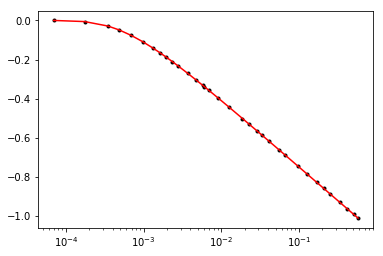

In [6]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, '.k')
plt.semilogx(tobs, hm[0], 'r')

In [7]:
print('correlation matrix')
print(cal.cormat)

correlation matrix
[[ 1.         -0.86628016]
 [-0.86628016  1.        ]]


## Calibrate parameters in multiple layers
Example showing how parameters can be optimized when multiple layers share the same parameter value.

In [118]:
ml = ModelMaq(kaq=[10., 10.], z=(-10, -16, -18, -25), c=[10.], Saq=[0.1, 1e-4], tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=1)
ml.solve()
hobs0 = ml.head(robs, 0, tobs, layers=[0])[0]
hobs1 = ml.head(robs, 0, tobs, layers=[1])[0]

self.neq  1
solution complete


In [119]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0-1', initial=10., pmin=0., pmax=30.)  # layers 0 and 1 have the same k-value
cal.set_parameter(name='Saq0', initial=1e-2, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='Saq1', initial=1e-4, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='c1', initial=1., pmin=0.1, pmax=200.)
cal.series(name='obs0', x=robs, y=0, layer=0, t=tobs, h=hobs0)
cal.series(name='obs1', x=robs, y=0, layer=1, t=tobs, h=hobs1)
cal.fit(report=False)
display(cal.parameters)

............................................................................


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0-1,10.000161,1.545898e-05,0.000155,0.00000,30.0,10.0000,"[10.00016139633568, 10.00016139633568]"
Saq0,0.100000,2.346147e-07,0.000235,0.00001,0.2,0.0100,[0.09999972370676695]
Saq1,0.000100,9.612878e-11,0.000096,0.00001,0.2,0.0001,[0.00010000052418362365]
c1,10.000055,5.080174e-06,0.000051,0.10000,200.0,1.0000,[10.000054570919623]


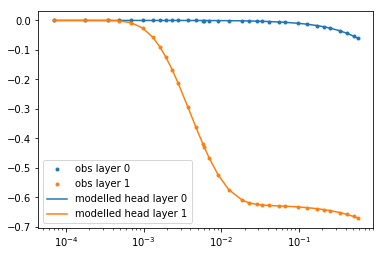

In [121]:
plt.semilogx(tobs, hobs0, '.C0', label="obs layer 0")
plt.semilogx(tobs, hobs1, '.C1', label="obs layer 1")

hm = ml.head(robs, 0, tobs)
plt.semilogx(tobs, hm[0], 'C0', label="modelled head layer 0")
plt.semilogx(tobs, hm[1], 'C1', label="modelled head layer 1")

plt.legend(loc="best")